In [1]:
import pandas as pd
import numpy as np


In [2]:
def preprocess_features(runs_df):
    # convert some int columns to labels
    runs = runs_df.assign(leg_id=runs_df.leg_nro.astype(str))
    runs = runs.assign(num_runs=runs.num_runs.astype(str))
    runs = runs.drop(["leg_nro", "year", "team"], axis=1)
    
    # A columns that contains most poular first names or NA
    runs["first_name"] = runs.name.str.split(" ", expand=True).iloc[:,0]
    runs["first_name"].describe()
    counts = runs["first_name"].value_counts()
    top_counts = counts[counts > 30]

    runs["tfn"] = runs["first_name"]

    def top_name(first_name): 
        if first_name in top_counts:
            return first_name
        else:
            return  "NA"

    runs["tfn"] = runs.apply(lambda run: top_name(run["first_name"]), axis=1)
    display(top_counts.describe())
    
    # Explode categories to dummy columns
    features = pd.get_dummies(runs[["tfn", "leg_id", "num_runs", "team_country"]], sparse=True)
    # allow linear regression to fit non-linear terms
    features["team_id_log2"] = np.log2(runs.team_id)
    features["team_id_log10"] = np.log10(runs.team_id)
    features["team_id_log100"] = np.log(runs.team_id) / np.log(100)
    features["team_id_square"] = np.square(runs.team_id)
    
    features.insert(0, "team_id", runs["team_id"])

    import json
    with open(f"data/preprocess_priors_feature_columns.json", 'w') as outfile:
        json.dump(features.columns.tolist(), outfile)

    x = features.values
    #x = features[["team_id", "team_id_log10", "team_id_log100", "team_id_log2", "team_id_square", "leg_id_1", "leg_id_2", "leg_id_3", "leg_id_4", "leg_id_5", "leg_id_6", "leg_id_7"]].values # Poista tää.
    y = np.log(runs.pace.values)
    y = y.reshape(len(y), 1)
    
    display(x.shape)
    display(y.shape)

    return (features, x, y)

In [3]:
in_file_name = 'data/runs_ju.tsv'
runs_df = pd.read_csv(in_file_name, delimiter="\t")

(features, x, y) = preprocess_features(runs_df)


count     342.000000
mean      181.415205
std       260.253424
min        31.000000
25%        45.000000
50%        76.000000
75%       188.500000
max      1787.000000
Name: first_name, dtype: float64

(76531, 398)

(76531, 1)

In [4]:
features.head(10)

,team_id,tfn_,tfn_NA,tfn_aapo,tfn_aarne,tfn_aaro,tfn_adam,tfn_aimo,tfn_aino,tfn_aki,...,team_country_SLO,team_country_SRB,team_country_SUI,team_country_SWE,team_country_UKR,team_country_USA,team_id_log2,team_id_log10,team_id_log100,team_id_square
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.000000,0.301030,0.150515,4
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4.000000,1.204120,0.602060,256
2,143,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7.159871,2.155336,1.077668,20449
3,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.584963,1.079181,0.539591,144
4,37,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5.209453,1.568202,0.784101,1369
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.000000,0.301030,0.150515,4
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,1
7,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.169925,0.954243,0.477121,81
8,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.584963,1.079181,0.539591,144
9,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4.392317,1.322219,0.661110,441


In [5]:
features.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 76531 entries, 0 to 76530
Columns: 398 entries, team_id to team_id_square
dtypes: Sparse[float64, nan](3), Sparse[int64, nan](2), Sparse[uint8, 0](393)
memory usage: 4.4 MB


In [6]:
import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.99, random_state=2019)
x_train.shape

(765, 398)

In [8]:
import matplotlib.pyplot as plt
def fit_and_test_model(model, x_train, x_test, y_train, y_test, fit_params={}):
    model.fit(x_train, y_train.ravel(), **fit_params)
    y_pred = np.exp(model.predict(x_test))
    print(f"Shapes: y_test={np.exp(y_test).shape} y_pred={y_pred.shape}")
    print("Mean squared error: %.3f" % mean_squared_error(np.exp(y_test), y_pred))
    print('Explained variance score: %.3f' % r2_score(np.exp(y_test), y_pred))
    
    plt.scatter(x_test[:,0], np.exp(y_test),  color='red', alpha=0.01)
    plt.scatter(x_test[:,0], y_pred, color='blue', alpha=0.01)
    plt.ylim(4, 20)
    plt.show()

In [ ]:
y_train.shape

(765, 1)

Shapes: y_test=(75766, 1) y_pred=(75766,)
Mean squared error: 22.983
Explained variance score: -1.599


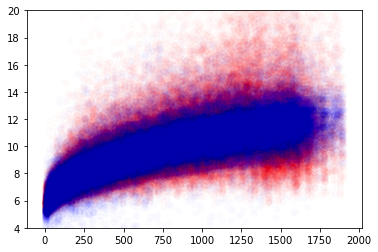

CPU times: user 4 s, sys: 445 ms, total: 4.44 s
Wall time: 2.67 s


In [ ]:
%%time
linear = linear_model.LinearRegression()
fit_and_test_model(linear, x_train, x_test, y_train, y_test)

      Iter       Train Loss   Remaining Time 
         1           0.0595           27.04s
         2           0.0548           26.18s
         3           0.0509           26.50s
         4           0.0474           26.48s
         5           0.0447           26.10s
         6           0.0423           26.44s
         7           0.0402           26.36s
         8           0.0386           25.91s
         9           0.0371           25.97s
        10           0.0359           25.90s
        20           0.0295           24.72s
        30           0.0266           22.49s
        40           0.0251           20.68s
        50           0.0240           19.22s
        60           0.0232           18.15s
        70           0.0225           17.39s
        80           0.0217           16.83s
        90           0.0212           16.48s
       100           0.0207           16.07s
       200           0.0172           13.86s
       300           0.0148           12.90s
       40

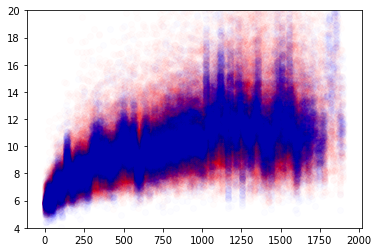

CPU times: user 26 s, sys: 247 ms, total: 26.3 s
Wall time: 25.6 s


In [ ]:
%%time

gbr = sklearn.ensemble.GradientBoostingRegressor(n_estimators=5100, random_state=0, verbose=1)

fit_and_test_model(gbr, x_train, x_test, y_train, y_test)

#print(f"feature_importances_: {gbr.feature_importances_}")
#gbr_features = pd.DataFrame({'feature':first_names.columns, 'importance': gbr.feature_importances_})
#gbr_features['feature'] = gbr_features['feature'].str.replace('top_first_name_','')
#display(gbr_features.sort_values(by="importance", ascending=False))

,team_id,tfn_,tfn_NA,tfn_aapo,tfn_aarne,tfn_aaro,tfn_adam,tfn_aimo,tfn_aino,tfn_aki,...,team_country_SRB,team_country_SUI,team_country_SWE,team_country_UKR,team_country_USA,team_id_log2,team_id_log10,team_id_log100,team_id_square,pace
33436,618,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,9.271463,2.790988,1.395494,381924,2.552955
30540,861,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,9.749869,2.935003,1.467502,741321,2.591217
41186,1414,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,10.465566,3.150449,1.575225,1999396,2.723333


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Created model


Multiprocess sampling (14 chains in 14 jobs)
NUTS: [sd, team_id_log100, team_id_log10, team_id_log2, Intercept, grp_sd, grp_mean]
Sampling 14 chains: 100%|██████████| 35000/35000 [05:44<00:00, 101.47draws/s]
There were 361 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 333 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7215970857608134, but should be close to 0.8. Try to increase the number of tuning steps.
There were 426 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 444 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6007215155199108, but 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1461be240>,
      dtype=object)

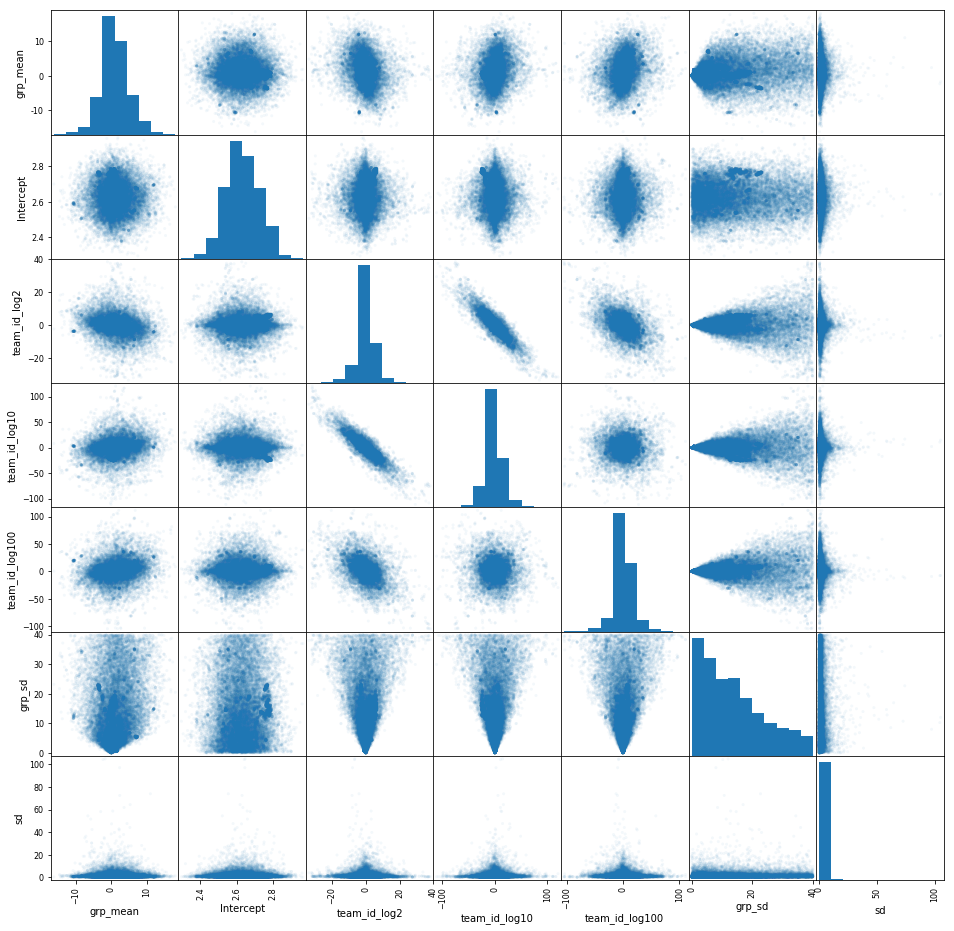

,grp_mean,Intercept,team_id_log2,team_id_log10,team_id_log100,grp_sd,sd
count,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000
mean,1.052671,2.630449,-0.050157,-0.608912,1.538624,13.764389,1.587618
std,3.874509,0.091562,5.644121,17.034175,16.691169,10.433516,2.777377
min,-16.230746,2.295627,-33.650937,-111.294859,-104.416627,0.028805,0.149492
25%,-1.076487,2.568626,-2.311197,-7.074128,-4.382607,5.072652,0.539650
50%,0.732942,2.627120,-0.095890,0.143602,0.936420,11.770878,0.897628
75%,3.151222,2.696445,2.331785,5.960298,8.001125,20.573199,1.629404
max,18.072035,2.962562,38.333613,120.518780,111.229144,39.976220,104.819240


In [ ]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'
os.environ['MKL_NUM_THREADS'] = '10'
os.environ['OMP_NUM_THREADS'] = '10'

import pymc3 as pm
import pmlearn
from pmlearn.linear_model import LinearRegression
print('Running on pymc-learn v{}'.format(pmlearn.__version__))


Running on pymc-learn v0.0.1.rc3


In [ ]:
import multiprocessing
multiprocessing.cpu_count()

12

In [ ]:
pmlearn_linear = LinearRegression()
fit_params={
    "inference_type": "nuts",
    "inference_args": {
        "cores": 2 * multiprocessing.cpu_count()
    }
}
fit_and_test_model(pmlearn_linear, pd.DataFrame(data=x_train), pd.DataFrame(x_test), y_train, y_test,fit_params)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, betas, alpha]
Sampling 4 chains:  12%|█▏        | 1182/10000 [05:10<1:28:35,  1.66draws/s]

In [ ]:
pmlearn_preds = pmlearn_linear.predict(pd.DataFrame(x_test), return_std=True)

In [ ]:
pred_errors = pd.DataFrame({
    'mean':np.exp(pmlearn_preds[0]), 
    'std':np.exp(pmlearn_preds[1]), 
    'true':np.exp(y_test).ravel(), 
    'error':np.abs(np.exp(y_test).ravel() -np.exp(pmlearn_preds[0])) / np.exp(pmlearn_preds[1])
})
display(pred_errors.head(10))
pred_errors.error.mean()

In [ ]:
pmlearn_linear.plot_elbo()

In [ ]:
pm.traceplot(pmlearn_linear.trace)

In [ ]:
pm.forestplot(pmlearn_linear.trace, varnames=["betas", "alpha", "s"]);

In [ ]:
pm.summary(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])

In [ ]:
pm.plot_posterior(pmlearn_linear.trace, varnames=["betas", "alpha", "s"],
                 figsize = [14, 8])

In [ ]:
pm.gelman_rubin(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])